## Analisis de tiempo en pasto Nariño para la automatizacion de mensajes sms

In [1]:
!pip3 install twilio

In [2]:
import os
import twilio
from twilio.rest import Client
from twilio_config import TWILIO_ACCOUNT_SID,TWILIO_AUTH_TOKEN,PHONE_NUMBER,API_KEY_WAPI
import time

from requests import Request, Session
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects
import json


import pandas as pd
import requests
from bs4  import BeautifulSoup
from tqdm import tqdm

from datetime import datetime


# Armado de la URL

In [3]:
query = 'Bogotá'
api_key = API_KEY_WAPI

url_clima = 'http://api.weatherapi.com/v1/forecast.json?key='+api_key+'&q='+query+'&days=1&aqi=no&alerts=no'
url_clima

'http://api.weatherapi.com/v1/forecast.json?key=c6405246306b48d189d162853241704&q=Bogotá&days=1&aqi=no&alerts=no'

In [4]:
response = requests.get(url_clima).json()

In [ ]:
response

In [6]:
response.keys()

dict_keys(['location', 'current', 'forecast'])

In [7]:
response['forecast']['forecastday'][0].keys()

dict_keys(['date', 'date_epoch', 'day', 'astro', 'hour'])

In [8]:
len(response['forecast']['forecastday'][0]['hour'])

24

In [9]:
response['forecast']['forecastday'][0]['hour'][0]

{'time_epoch': 1713330000,
 'time': '2024-04-17 00:00',
 'temp_c': 10.4,
 'temp_f': 50.7,
 'is_day': 0,
 'condition': {'text': 'Partly Cloudy ',
  'icon': '//cdn.weatherapi.com/weather/64x64/night/116.png',
  'code': 1003},
 'wind_mph': 4.3,
 'wind_kph': 6.8,
 'wind_degree': 111,
 'wind_dir': 'ESE',
 'pressure_mb': 1019.0,
 'pressure_in': 30.1,
 'precip_mm': 0.0,
 'precip_in': 0.0,
 'snow_cm': 0.0,
 'humidity': 93,
 'cloud': 42,
 'feelslike_c': 9.7,
 'feelslike_f': 49.5,
 'windchill_c': 9.7,
 'windchill_f': 49.5,
 'heatindex_c': 10.4,
 'heatindex_f': 50.7,
 'dewpoint_c': 9.2,
 'dewpoint_f': 48.6,
 'will_it_rain': 0,
 'chance_of_rain': 0,
 'will_it_snow': 0,
 'chance_of_snow': 0,
 'vis_km': 10.0,
 'vis_miles': 6.0,
 'gust_mph': 8.1,
 'gust_kph': 13.0,
 'uv': 1.0}

In [10]:
response['forecast']['forecastday'][0]['hour'][0]['time'].split()[0]

'2024-04-17'

In [11]:
response['forecast']['forecastday'][0]['hour'][1]['time'].split()[1].split(':')[0]

'01'

In [12]:
response['forecast']['forecastday'][0]['hour'][0]['will_it_rain']

0

In [13]:
response['forecast']['forecastday'][0]['hour'][2]['chance_of_rain']

0

#  Tomando el Dataframe

In [16]:
def get_forecast(response,i):

    fecha = response['forecast']['forecastday'][0]['hour'][i]['time'].split()[0]
    hora = int(response['forecast']['forecastday'][0]['hour'][i]['time'].split()[1].split(':')[0])
    condicion = response['forecast']['forecastday'][0]['hour'][i]['condition']['text']
    tempe = float(response['forecast']['forecastday'][0]['hour'][i]['temp_c'])
    rain = response['forecast']['forecastday'][0]['hour'][i]['will_it_rain']
    prob_rain = response['forecast']['forecastday'][0]['hour'][i]['chance_of_rain']

    return fecha,hora,condicion,tempe,rain,prob_rain

In [17]:
datos = []

for i in tqdm(range(len(response['forecast']['forecastday'][0]['hour'])),colour = 'green'):

    datos.append(get_forecast(response,i))


100%|██████████| 24/24 [00:00<00:00, 93206.76it/s]


In [18]:
datos[0]

('2024-04-17', 0, 'Partly Cloudy ', 10.4, 0, 0)

In [19]:
col = ['Fecha','Hora','Condicion','Temperatura','Lluvia','prob_lluvia']
df = pd.DataFrame(datos,columns=col)
df = df.sort_values(by = 'Hora',ascending = True)
df

,Fecha,Hora,Condicion,Temperatura,Lluvia,prob_lluvia
0,2024-04-17,0,Partly Cloudy,10.4,0,0
1,2024-04-17,1,Partly Cloudy,9.9,0,0
2,2024-04-17,2,Partly Cloudy,9.6,0,0
3,2024-04-17,3,Partly Cloudy,9.5,0,0
4,2024-04-17,4,Partly Cloudy,9.2,0,0
5,2024-04-17,5,Partly Cloudy,9.0,0,0
6,2024-04-17,6,Partly Cloudy,9.1,0,0
7,2024-04-17,7,Partly Cloudy,11.9,0,0
8,2024-04-17,8,Patchy rain nearby,14.7,0,61
9,2024-04-17,9,Sunny,17.1,0,0


Graficas Temp vs hora

In [29]:
import matplotlib.pyplot as plt
import seaborn as snb

In [32]:
df.head()

,Fecha,Hora,Condicion,Temperatura,Lluvia,prob_lluvia
0,2024-04-17,0,Partly Cloudy,10.4,0,0
1,2024-04-17,1,Partly Cloudy,9.9,0,0
2,2024-04-17,2,Partly Cloudy,9.6,0,0
3,2024-04-17,3,Partly Cloudy,9.5,0,0
4,2024-04-17,4,Partly Cloudy,9.2,0,0


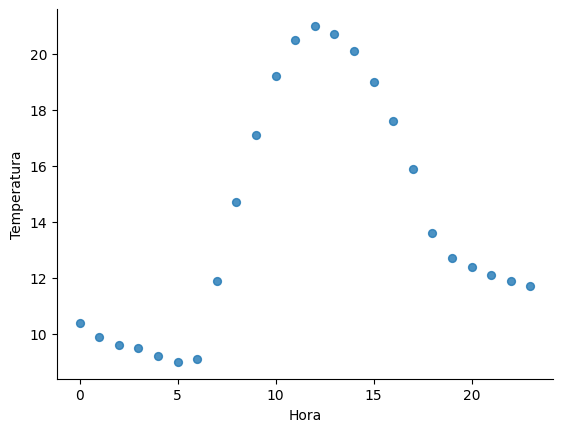

In [41]:
# @title Hora vs Temperatura

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='Hora', y='Temperatura', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

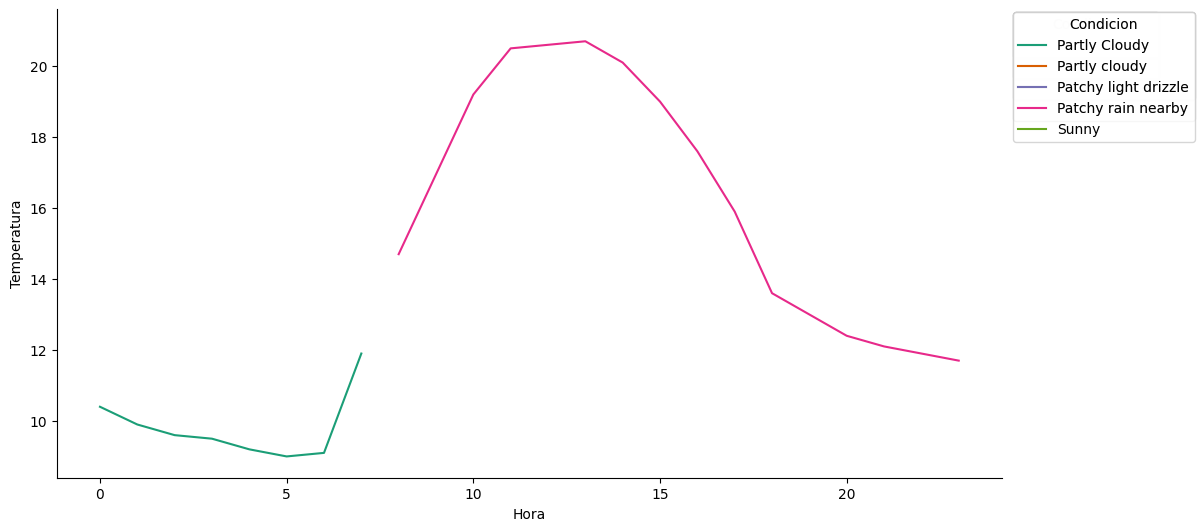

In [40]:
# @title Hora vs Temperatura

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Hora']
  ys = series['Temperatura']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('Hora', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Condicion')):
  _plot_series(series, series_name, i)
  fig.legend(title='Condicion', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Hora')
_ = plt.ylabel('Temperatura')

In [21]:
df[df['Lluvia']==1]

,Fecha,Hora,Condicion,Temperatura,Lluvia,prob_lluvia
10,2024-04-17,10,Patchy rain nearby,19.2,1,72
11,2024-04-17,11,Patchy rain nearby,20.5,1,88
12,2024-04-17,12,Partly cloudy,21.0,1,100
13,2024-04-17,13,Patchy rain nearby,20.7,1,100
14,2024-04-17,14,Patchy rain nearby,20.1,1,100
15,2024-04-17,15,Patchy rain nearby,19.0,1,100
16,2024-04-17,16,Patchy rain nearby,17.6,1,100
17,2024-04-17,17,Patchy rain nearby,15.9,1,100
18,2024-04-17,18,Patchy rain nearby,13.6,1,100
19,2024-04-17,19,Patchy light drizzle,12.7,1,100


In [22]:
df_rain =  df[(df['Lluvia']==1) & (df['Hora']>6) & (df['Hora']< 22)]
df_rain = df_rain[['Hora','Condicion']]
df_rain.set_index('Hora', inplace = True)

In [23]:
df['Fecha'][0]

'2024-04-17'

In [24]:
df_rain

,Condicion
Hora,
10,Patchy rain nearby
11,Patchy rain nearby
12,Partly cloudy
13,Patchy rain nearby
14,Patchy rain nearby
15,Patchy rain nearby
16,Patchy rain nearby
17,Patchy rain nearby
18,Patchy rain nearby


In [25]:
'\nHola! \n\n\n El pronostico del tiempo hoy '+ df['Fecha'][0] +' en ' + query +' es : \n\n\n ' + str(df_rain)

'\nHola! \n\n\n El pronostico del tiempo hoy 2024-04-17 en Bogotá es : \n\n\n                  Condicion\nHora                      \n10      Patchy rain nearby\n11      Patchy rain nearby\n12           Partly cloudy\n13      Patchy rain nearby\n14      Patchy rain nearby\n15      Patchy rain nearby\n16      Patchy rain nearby\n17      Patchy rain nearby\n18      Patchy rain nearby\n19    Patchy light drizzle\n20      Patchy rain nearby'

In [26]:
PHONE_NUMBER

'+12059527269'

# Mensaje SMS desde Twilio

In [28]:
time.sleep(2)
account_sid = TWILIO_ACCOUNT_SID
auth_token = TWILIO_AUTH_TOKEN

client = Client(account_sid, auth_token)

message = client.messages \
                .create(
                     body='\nHola! \n\n\n El pronostico de lluvia hoy '+ df['Fecha'][0] +' en ' + query +' es : \n\n\n ' + str(df_rain),
                     from_=PHONE_NUMBER,
                     to='+57xxxxxxx'
                 )

print('Mensaje Enviado ' + message.sid)

Mensaje Enviado SMcaa95b5c7105c679396055ed25666e5f
